In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optims
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

**Load Data**

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
test_set = datasets.MNIST(root = './data', train = False, download = True, transform = transform)

  0%|          | 16384/9912422 [00:00<01:14, 133613.86it/s]

9920512it [00:00, 31449170.84it/s]                           


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 436781.42it/s]
  1%|          | 16384/1648877 [00:00<00:11, 142778.88it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7083151.83it/s]                            
8192it [00:00, 179842.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


此實驗室使用mnist的數字做為資料，可以知道要預測的是圖片，那訓練時，輸入的資料X是指該image的部分的pixel的位置，和這位置上有的target值，那Yt也就是整張圖要如何產生呢?這裡它需要先Sample出Z，而我們需要給予Xt，那這裡因為是要輸出整張圖片，所以我們需要輸入整張圖的Xt，你也可以想成是x1~x784，而我們對應產生的就是y1~y784。<br>
那這對應到paper中提到，在target set中，我們會包含一些context set，而這是因為在訓練或是取得z是透過這些已知的context set也就是要predict的部分的pixel的information。<br>

#補充
在看paper時還沒想通為什麼gaussian process可以看成是一個stochastic process能map所謂的X1~Xn => Y1~ Yn，這到底是啥意思，以前學GP時它不是只吃一個數值輸出另一個數值嗎。那這裡Sequence想表示的是一筆資料其中它有n個部分，有點類似語言的資料，一個句子有很多個字，而這裡一張圖片有很多的pixel，而如果將pixel以Sequence表示，那清楚地，這pixel的就是我們想學的，那這裡的function mapping 是given pixel的location去predict pixel的值，所以可以知道X1~n指的是一串選取的index有n個的pixel的位置，而其中我們將它與它的target，Y1~n也就是這n個pixel的顏色值，作為是context set，而想當然在做output時，X應該要包含所有的pixel的位置，這樣輸出的Y才會是所有pixel的顏色值，而這也說明paper中的一些部分。

In [ ]:
def get_element_index(num_index):
    batch_index = np.random.choice(784,num_index)
    batch_index = torch.tensor(batch_index).to(device)
    return batch_index
def get_context_set(h,w):
    rows = torch.linspace(0,1,h,device = device)
    cols = torch.linspace(0,1,w,device = device)
    grid = torch.stack([cols.repeat(h,1).t().contiguous().view(-1),rows.repeat(w)],dim = 1)
    grid = grid.unsqueeze(0).to(device)
    return grid
def index_to_target(index, target_sequence):
    return torch.index_select(target_sequence,dim = 1,index = index)
def index_to_context(index,full_context_set,batch_size):
    select_context = torch.index_select(full_context_set, dim = 1, index = index)
    return select_context.repeat(batch_size, 1, 1)


In [ ]:
class NP(nn.Module):
    def __init__(self,context_dim, target_dim, h_dim, r_dim, z_dim):
        super().__init__()
        self.h1 = nn.Linear(context_dim + target_dim,h_dim)
        self.h2 = nn.Linear(h_dim,h_dim)
        self.h3 = nn.Linear(h_dim,r_dim)
        self.relu = nn.ReLU()
        
        self.s1 = nn.Linear(context_dim + target_dim,h_dim)
        self.s2 = nn.Linear(h_dim, h_dim)
        self.s3 = nn.Linear(h_dim,r_dim)
        
        self.z_mean = nn.Linear(r_dim, z_dim)
        self.z_std = nn.Linear(r_dim, z_dim)
        
        self.g1 = nn.Linear(z_dim + 2, h_dim)
        self.g2 = nn.Linear(h_dim, h_dim)
        self.g3 = nn.Linear(h_dim,target_dim)
        self.sigmoid = nn.Sigmoid()
        
        
        self.full_context_set = get_context_set(28,28)
    def aggregator(self, r_input):
        return torch.mean(r_input,dim = 1)
      
    def hidden_layer(self,c_t_input):
        h = self.h1(c_t_input)
        h = self.relu(h)
        h = self.h2(h)
        h = self.relu(h)
        r = self.h3(h)
        
        return r
    def reparameter_trick(self,r_input):
        z_mean = self.z_mean(r_input)
        z_std = self.z_std(r_input)
        epsilon = torch.randn(z_mean.size()).to(device)
        z_sample = z_mean + epsilon * z_std
        z_sample = z_sample.unsqueeze(1).expand(-1,784,-1)
        kl_loss = KL_Loss(z_mean,z_std)
        return z_sample, kl_loss
      
    def decode_layer(self,z_c_input):
        g = self.g1(z_c_input)
        g = self.relu(g)
        g = self.g2(g)
        g = self.relu(g)
        g = self.g3(g)
        t = self.sigmoid(g)
        return t
      
    def forward(self,c_input, t_input):
        c_t_input = torch.cat((c_input,t_input),dim = 2)
        r = self.hidden_layer(c_t_input)
        r_aggre = self.aggregator(r)
        z_sample,kl_loss = self.reparameter_trick(r_aggre)
        full_c_input = self.full_context_set.expand(c_input.size()[0],-1,-1).to(device)
        z_c_input = torch.cat((z_sample,full_c_input),dim = 2)
        
        t = self.decode_layer(z_c_input)
            
        return t, kl_loss

      
def Reconstruction_Loss(predict_t, true_t):
    return F.binary_cross_entropy(predict_t, true_t, reduction="sum")
def KL_Loss(z_mean,z_std):
    return torch.sum( -0.5*(1 + z_std - z_mean * z_mean - torch.exp(z_std)))
    

In [ ]:
config = {
    'context_dim':2,
    'target_dim':1,
    'h_dim':128,
    'r_dim':128,
    'z_dim':128
}

In [ ]:
neuralp = NP(**config)
neuralp = neuralp.to(device)
adam = optims.Adam(neuralp.parameters())

In [ ]:
Epoch = 100
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset = train_set, shuffle = True, batch_size = batch_size)
for epoch in range(Epoch):
    for i,data in enumerate(train_loader):
        target_sequence,_ = data
        target_sequence = target_sequence.to(device)
        target_sequence = target_sequence.view(batch_size,-1,1)
        
        context_sequence = get_context_set(28,28)
        num_element_index = np.random.randint(10,680)
        element_index = get_element_index(num_element_index)
        select_target_sequence = index_to_target(element_index, target_sequence)
        select_context_sequence = index_to_context(element_index, context_sequence, batch_size)
        predict_target_sequence, kl_loss = neuralp(select_context_sequence,select_target_sequence)
        adam.zero_grad()        
        loss = Reconstruction_Loss(predict_target_sequence,target_sequence) + kl_loss
        loss.backward()
        adam.step()
        if i %1000 ==0:
            print(Reconstruction_Loss(predict_target_sequence,target_sequence))
            print(loss)

tensor(14416.4834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14434.6611, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11603.9785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11616.8896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12702.5742, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12718.4141, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12640.4102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12655.2959, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13624.9141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13639.5996, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12553.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12568.9521, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14309.9951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14326.1514, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12661.6738, device='cuda:0', grad_fn=<BinaryCrossEntrop

KeyboardInterrupt: ignored

In [ ]:
def plot_result(element_index, predict_target_sequence, target_sequence):
    predict_target_sequence = predict_target_sequence.detach().cpu().numpy()
    target_sequence = target_sequence.detach().cpu().numpy()
    predict_target_sequence = predict_target_sequence.reshape(-1,1,28,28)
    target_sequence = target_sequence.reshape(-1,1,28,28)
    element_index = element_index.detach().cpu().numpy()
    
    for i in range(10):
        fake_image = np.zeros((28,28,3)).reshape(784,3)
        fake_image[:,[0,2]] = 0
        fake_image[element_index,1] = target_sequence[i].reshape(784)[element_index]
        fake_image = fake_image.reshape((28,28,3))
        plt.subplots(1,3)
        plt.subplot(1,3,1)      
        plt.imshow(fake_image)
        plt.subplot(1,3,2)
        plt.imshow(predict_target_sequence[i,0])
        plt.subplot(1,3,3)
        plt.imshow(target_sequence[i,0])

torch.Size([100, 1, 28, 28])
tensor(11588.4502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


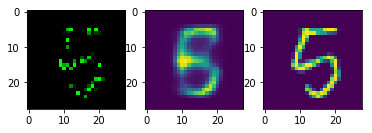

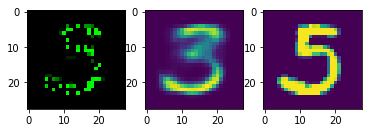

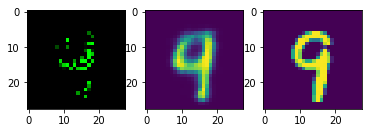

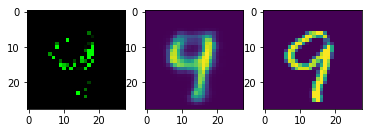

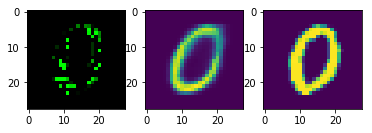

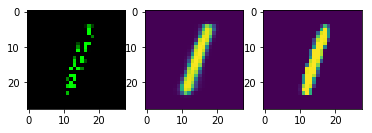

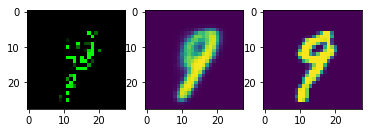

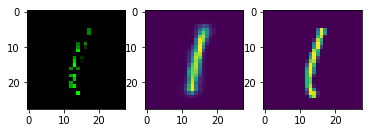

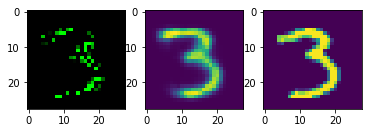

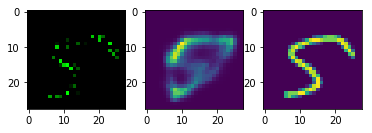

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset = test_set, shuffle = True, batch_size = batch_size)
for epoch in range(1):
    for i, data in enumerate(test_loader):
        target_sequence, _ = data
        print(target_sequence.size())
        target_sequence = target_sequence.to(device)
        target_sequence = target_sequence.view(batch_size, -1, 1)
        context_sequence = get_context_set(28,28)
        num_index = np.random.randint(300,350)
        element_index = get_element_index(num_index)
        select_context_sequence = index_to_context(element_index, context_sequence, batch_size)
        select_target_sequence = index_to_target(element_index, target_sequence)
        
        predict_target_sequence, _ = neuralp(select_context_sequence, select_target_sequence)
        print(Reconstruction_Loss(predict_target_sequence, target_sequence))
        plot_result(element_index, predict_target_sequence, target_sequence)
        
        break

GP並不是一筆資料就一個數值，向上述這樣的image其中每個pixel都像是單獨的一筆數值，而要找到F使得它能根據擁有的一些資訊去推得整體的。

In [ ]:
data = np.random.normal(size = (5,5,5)).astype('float32')

In [ ]:
data = torch.tensor(data)

In [ ]:
print(data.type())

torch.FloatTensor


In [ ]:
linear = nn.Linear(5,10)

In [ ]:
data = linear(data)

In [ ]:
print(data.size())

torch.Size([5, 5, 10])


In [ ]:
array = np.random.randint(0,1,(100,))

In [ ]:
print(array)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
http://vividfree.github.io/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0/2017/08/05/understanding-product-quantization

SyntaxError: ignored